In [1]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt


import seaborn as sns



In [2]:
# 파일 호출
data_path: str = "data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)
df


,ID,target,_type
0,2023-01-01 00:00:00,2.0,train
1,2023-01-01 01:00:00,1.0,train
2,2023-01-01 02:00:00,1.0,train
3,2023-01-01 03:00:00,1.0,train
4,2023-01-01 04:00:00,2.0,train
...,...,...,...
2787,2024-04-26 03:00:00,NaN,test
2788,2024-04-26 04:00:00,NaN,test
2789,2024-04-26 05:00:00,NaN,test
2790,2024-04-26 06:00:00,NaN,test


In [3]:
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]
# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")

100%|██████████| 107/107 [00:02<00:00, 45.91it/s]


In [4]:
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type": "_type",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_index": "coinbase_premium_index",
    "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd": "long_liquidations_usd",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd": "short_liquidations_usd",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "buy_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "buy_sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
    "hourly_network-data_addresses-count_addresses_count_active": "active_count",
    "hourly_network-data_addresses-count_addresses_count_receiver": "receiver_count",
    "hourly_network-data_addresses-count_addresses_count_sender": "sender_count",
}
df = df[cols_dict.keys()].rename(cols_dict, axis=1)
df.shape


(11552, 19)

In [5]:
df = df.assign(
    liquidation_diff=df["long_liquidations"] - df["short_liquidations"],
    liquidation_usd_diff=df["long_liquidations_usd"] - df["short_liquidations_usd"],
    volume_diff=df["buy_volume"] - df["sell_volume"],
    liquidation_diffg=np.sign(df["long_liquidations"] - df["short_liquidations"]),
    liquidation_usd_diffg=np.sign(df["long_liquidations_usd"] - df["short_liquidations_usd"]),
    volume_diffg=np.sign(df["buy_volume"] - df["sell_volume"]),
    buy_sell_volume_ratio=df["buy_volume"] / (df["sell_volume"] + 1),
)
# category, continuous 열을 따로 할당해둠

In [ ]:
df['mean_7days'] = df['volume_diff'].rolling(window=168).mean()  # 7 days if hourly data
df['mean_1day'] = df['volume_diff'].rolling(window=24).mean()    # 1 day if hourly data
df['mean_1month'] = df['volume_diff'].rolling(window=720).mean()  # 1 month if hourly data (30 days)
df['slope_7days'] = df['mean_7days'].diff()
df['slope_1day'] = df['mean_1day'].diff()
df['slope_1month'] = df['mean_1month'].diff()
# Calculate the differences in moving averages
df['mean_diff_7days_1day_volume'] = df['mean_7days'] - df['mean_1day']
df['mean_diff_1month_7days_volume'] = df['mean_1month'] - df['mean_7days']

df['mean_50'] = df['volume_diff'].rolling(window=50).mean()  # 50-period moving average
df['mean_100'] = df['volume_diff'].rolling(window=100).mean()

# Cross-signal generation
df['cross_volume_diff'] = np.where(df['mean_50'] > df['mean_100'], 1, 0)
df['cross_shifted_volume_diff'] = df['cross_volume_diff'].shift(1)
df['cross_signal_volume_diff'] = np.where(df['cross_volume_diff'] != df['cross_shifted_volume_diff'], 1, 0)

# # Rolling standard deviation for volatility
# df['rolling_std_50_volume_diff'] = df['volume_diff'].rolling(window=50).std()
# df['rolling_std_100_volume_diff'] = df['volume_diff'].rolling(window=100).std()

# # Drop intermediate moving averages
df.drop(columns=['mean_7days', 'mean_1day', 'mean_1month'], inplace=True)

df['mean_7days'] = df['liquidation_diff'].rolling(window=168).mean()  # 7 days if hourly data
df['mean_1day'] = df['liquidation_diff'].rolling(window=24).mean()    # 1 day if hourly data
df['mean_1month'] = df['liquidation_diff'].rolling(window=720).mean()  # 1 month if hourly data (30 days)

df['mean_diff_7days_1day_liquidation'] = df['mean_7days'] - df['mean_1day']
df['mean_diff_1month_7days_liquidation'] = df['mean_1month'] - df['mean_7days']

#Cross-signal generation
df['cross_liquidation_diff'] = np.where(df['mean_50'] > df['mean_100'], 1, 0)
df['cross_shifted_liquidation_diff'] = df['cross_liquidation_diff'].shift(1)
df['cross_signal_liquidation_diff'] = np.where(df['cross_liquidation_diff'] != df['cross_shifted_liquidation_diff'], 1, 0)

# # Rolling standard deviation for volatility
# df['rolling_std_50_liquidation_diff'] = df['liquidation_diff'].rolling(window=50).std()
# df['rolling_std_100_liquidation_diff'] = df['liquidation_diff'].rolling(window=100).std()

df.drop(columns=['mean_7days', 'mean_1day', 'mean_1month','mean_50','mean_100'], inplace=True)

In [ ]:
category_cols: List[str] = ["liquidation_diffg", "liquidation_usd_diffg", "volume_diffg",'cross_volume_diff','cross_shifted_volume_diff',
                            'cross_signal_volume_diff','mean_diff_7days_1day_volume','mean_diff_1month_7days_volume',
                            'mean_diff_7days_1day_liquidation','mean_diff_1month_7days_liquidation',
                            'cross_liquidation_diff','cross_shifted_liquidation_diff',
                           'cross_signal_liquidation_diff','slope_7days','slope_1day','slope_1month']
conti_cols: List[str] = [_ for _ in df.columns if _ not in ["ID", "target", "_type"]+category_cols]  





In [ ]:
conti_cols

# check for interval using PACF



In [7]:
pip install statsmodels

  Using cached patsy-0.5.6-py2.py3-none-any.whl.metadata (3.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 23.1 MB/s eta 0:00:00a 0:00:01
Using cached patsy-0.5.6-py2.py3-none-any.whl (233 kB)
Note: you may need to restart the kernel to use updated packages.


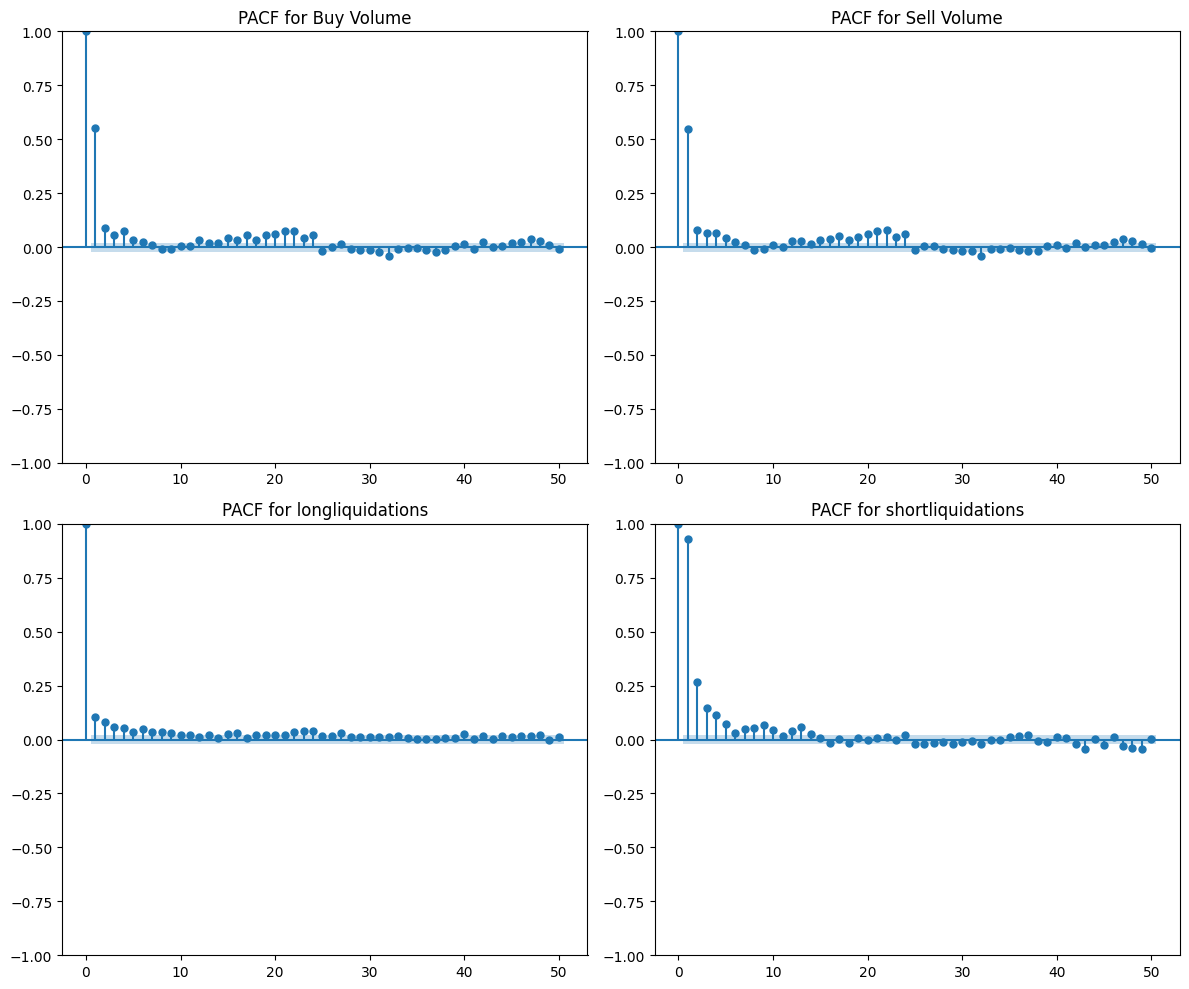

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
eda=df[df['_type']=='train']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns of plots

plot_pacf(eda['buy_volume'], lags=50, ax=axes[0, 0])
axes[0, 0].set_title('PACF for Buy Volume')

plot_pacf(eda['sell_volume'], lags=50, ax=axes[0, 1])
axes[0, 1].set_title('PACF for Sell Volume')

plot_pacf(eda['sender_count'].dropna(), lags=50, ax=axes[1, 0])
axes[1, 0].set_title('PACF for longliquidations')

plot_pacf(eda['coinbase_premium_index'].dropna(), lags=50, ax=axes[1, 1])
axes[1, 1].set_title('PACF for shortliquidations')

plt.tight_layout()
plt.show()


In [ ]:
def shift_feature(
    df: pd.DataFrame,
    conti_cols: List[str],
    intervals: List[int],
) -> List[pd.Series]:
    """
    연속형 변수의 shift feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        intervals (List[int]): shifted intervals
    Return:
        List[pd.Series]
    """
    df_shift_dict = [
        df[conti_col].shift(interval).rename(f"{conti_col}_{interval}")
        for conti_col in conti_cols
        for interval in intervals
    ]
    return df_shift_dict

# 최대 24시간의 shift 피쳐를 계산
shift_list = shift_feature(
    df=df, conti_cols=conti_cols, intervals=[ 1,2,3,4,6,12,24,168]
)
# concat 하여 df 에 할당
df = pd.concat([df, pd.concat(shift_list, axis=1)], axis=1)

In [ ]:
from typing import List
import pandas as pd

def rolling_feature(
   df: pd.DataFrame,
   conti_cols: List[str],
   intervals: List[int],
   funcs: List[str],
   **params,
) -> pd.DataFrame:
   """
   Create rolling features
   Args:
       df (pd.DataFrame): Sorted dataframe
       conti_cols (List[str]): continuous colnames
       intervals (List[str]): rolling window widths
       funcs (List[str]): aggregation functions e.g. ["mean", "median", "max"]
       **params: more input for rolling
   Returns:
       pd.DataFrame
   """
   df_rolling_list = [
       df[conti_col]
       .rolling(interval, **params)
       .agg({f"{conti_col}": func})
       .rename({conti_col: f"{conti_col}_{func}_{interval}"}, axis=1)
       for conti_col in conti_cols
       for interval in intervals
       for func in funcs
   ]
   return pd.concat(df_rolling_list, axis = 1)


In [ ]:
#'block-interval_block_interval'
conti_cols = ["coinbase_premium_gap", "coinbase_premium_index",'buy_volume','sell_volume','volume_diff','liquidation_diff','funding_rates',
              'open_interest','buy_ratio','sell_ratio','active_count','sender_count',"receiver_count"]

rolling_df = rolling_feature(
   df = df,
   conti_cols=conti_cols,
   intervals=[ 12,24,168],
   funcs=["mean", 'std','max','min'],
   min_periods = 1,
   closed = "left",
)

df=pd.concat([df, rolling_df], axis = 1)

In [ ]:
df.info()

In [ ]:
total_columns = df.columns[3:]
remove_high_corr = []
df_corr = df[total_columns].corr()

for c in total_columns:
  for c1 in df_corr[abs(df_corr[c]) == 1].index:
    if (c != c1) & (c not in remove_high_corr):
      remove_high_corr.append(c1)

In [ ]:
df.info()

In [ ]:
_target = df["target"]
df = df.ffill().fillna(-999).assign(target = _target)

# _type에 따라 train, test 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

In [ ]:
# Step 1: Apply Window Slicing to Data Where Target is 0 or 3
df_filtered = train_df[(train_df['target'] == 0) | (train_df['target'] == 3)]
df_filtered
# Example window slicing function
# def window_slicing(time_series, window_size,step_size):
#     slices = []
#     for i in range(0,len(time_series) - window_size + 1,step_size):
#         window = time_series[i: i + window_size]
#         slices.append(window)
#     return np.array(slices)
def window_slicing(df: pd.DataFrame, window_size: int, step_size: int) -> pd.DataFrame:
    sliced_data = []
    
    for start in range(0, len(df) - window_size + 1, step_size):
        end = start + window_size
        window_df = df.iloc[start:end].copy()
        # window_df['window_start_index'] = start
        sliced_data.append(window_df)
    
    sliced_data_df = pd.concat(sliced_data, axis=0).reset_index(drop=True)
    return sliced_data_df

# Example window size (24 hours for 1 day window)
window_size = 24
step_size=12
sliced_data = window_slicing(df_filtered, window_size,step_size)
augmented_data=sliced_data
# augmented_data = pd.DataFrame()
# for i in sliced_data:
#     i_df = pd.DataFrame(i, columns=df_filtered.columns)
#     augmented_data = pd.concat([augmented_data, i_df], axis=0)
# augmented_data = augmented_data.astype(df_filtered.dtypes.to_dict())
# augmented_data.shape


In [ ]:
# Step 2: Apply Noise Injection to the Sliced Data (excluding 'id' and 'target')
# def add_noise_to_data(df, noise_level=0.01):
#     df_noisy = df.copy()

#     # Exclude 'id' and 'target' columns from noise injectbion
#     feature_columns = df.columns.difference(['ID', 'target','_type'])
    
#     # Generate noise for the feature columns
#     noise = np.random.normal(0, noise_level, size=df[feature_columns].shape)
    
#     # Apply noise to feature columns
#     df_noisy[feature_columns] = df[feature_columns] + noise
    
#     return df_noisy
def noise_injection(df: pd.DataFrame, noise_level: float = 0.01, decay: float = 0.99, seed : int = 42) -> pd.DataFrame:
    df_noisy = df.copy()
    np.random.seed(seed)
    time_steps = np.arange(len(df_noisy))
    feature_columns = list(df.columns.difference(['ID', 'target','_type']) )
    feature_columns+=["liquidation_diffg", "liquidation_usd_diffg", "volume_diffg",'cross_volume_diff','cross_shifted_volume_diff',
                            'cross_signal_volume_diff']
    for col in feature_columns:
        noise = np.random.normal(0, noise_level*df_noisy[col].std(), size=df_noisy[col].shape)
        decays = decay ** time_steps
        df_noisy[col] = df_noisy[col] + noise * decays
    
    return df_noisy

# Apply noise to the sliced data
augmented_noisy_data = noise_injection(augmented_data, noise_level=0.01,decay=0.99,seed=42)

In [ ]:
augmented_noisy_data.columns
train_1_2=train_df[(train_df['target'] != 0) & (train_df['target'] != 3)]
train_df_augmented=pd.concat([train_1_2,augmented_noisy_data])

In [ ]:
train_df_augmented.shape

In [ ]:

train_df_augmented['target'].value_counts()/len(train_df_augmented)

In [ ]:
# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
# _target = df["target"]
# df = df.ffill().fillna(-999).assign(target = _target)

# # _type에 따라 train, test 분리
# train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
# test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(
    train_df_augmented.drop(["target", "ID"], axis=1), 
    train_df_augmented["target"].astype(int), 
    test_size=0.2,
    random_state=42,
    # stratify=train_df["target"].astype(int)
)
x_train.shape

In [ ]:
def train_lgmClassifier(x_train,x_valid,y_train,y_valid):
    

# lgb dataset
    train_data = lgb.Dataset(x_train, label=y_train)
    valid_data = lgb.Dataset(x_valid, label=y_valid, reference=train_data)

# lgb params
    params = {
        "boosting_type": "gbdt",
        "objective": "multiclass",
        "metric": "multi_logloss",
        "num_class": 4,
        "num_leaves": 50,
        "learning_rate": 0.05,
        "n_estimators": 50,
        "random_state": 42,
        "verbose": 0,
    }

# lgb train
    lgb_model = lgb.train(
        params=params,
        train_set=train_data,
        valid_sets=valid_data,
    )

# lgb predict
    y_valid_pred = lgb_model.predict(x_valid)
    y_valid_pred_class = np.argmax(y_valid_pred, axis = 1)

# score check
    accuracy = accuracy_score(y_valid, y_valid_pred_class)
    auroc = roc_auc_score(y_valid, y_valid_pred, multi_class="ovr")

    print(f"acc: {accuracy}, auroc: {auroc}")
    return lgb_model,accuracy,params
lgb_model,accuracy,params=train_lgmClassifier(x_train,x_valid,y_train,y_valid)

In [ ]:
importance = lgb_model.feature_importance()
feature_names=train_df.drop(["target", "ID"], axis = 1).columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
})

# Sort by importance (optional)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the DataFrame
print(feature_importance_df[:50])
# a=feature_importance_df[:100]
# train_df[a.loc[:,'Feature']]

In [ ]:
from sklearn.model_selection import StratifiedKFold  # For stratified cross-validation
from sklearn.feature_selection import SelectKBest, f_classif  # For feature selection

pred_lgm = []
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation with stratification
for train_idx, val_idx in k_fold.split(train_df_augmented.drop(['ID', "target"], axis=1), train_df_augmented["target"]):
    # Train and validation sets
    x_tr = train_df_augmented.drop(["ID", "target"], axis=1).iloc[train_idx]  # Dropping both 'ID' and 'target'
    y_tr = train_df_augmented['target'].iloc[train_idx]
    x_val = train_df_augmented.drop(["ID", "target"], axis=1).iloc[val_idx]  # Dropping both 'ID' and 'target'
    y_val = train_df_augmented['target'].iloc[val_idx]

    # Select top 200 features using SelectKBest with f_classif
    # n_feature = 200
    # selector1 = SelectKBest(f_classif, k=n_feature)
    # x_tr_sel = selector1.fit_transform(x_tr, y_tr)
    # x_val_sel = selector1.transform(x_val)

    # Assuming train_lgmClassifier is a function you defined to train LightGBM and return accuracy
    _, accuracy,_ = train_lgmClassifier(x_tr, x_val, y_tr, y_val)

    # Store the accuracy for each fold
    pred_lgm.append(accuracy)


# No feature selection train

In [ ]:
x_train = train_df_augmented.drop(["target", "ID"], axis = 1)
y_train = train_df_augmented["target"].astype(int)
train_data = lgb.Dataset(x_train, label=y_train)
lgb_model = lgb.train(
    params=params,
    train_set=train_data,
)

# Feature selection train

In [ ]:

x_train = train_df_augmented.drop(["target", "ID"], axis = 1)
y_train = train_df_augmented["target"].astype(int)
n_feature = 200
selector1 = SelectKBest(f_classif, k=n_feature)
x_tr_sel = selector1.fit_transform(x_train, y_train)
train_data = lgb.Dataset(x_tr_sel, label=y_train)
lgb_model = lgb.train(
    params=params,
    train_set=train_data,
)

# No feature selection

In [ ]:

y_test_pred = lgb_model.predict(test_df.drop(["target", "ID"], axis = 1))
y_test_pred_class = np.argmax(y_test_pred, axis = 1)

# Feature anova top 200 selection

In [ ]:
# selected_features = x_train.columns[selector1.get_support()]
x_test=test_df.drop(["target", "ID"], axis = 1)
x_test_sel = selector1.transform(x_test)

y_test_pred = lgb_model.predict(x_test_sel)
y_test_pred_class = np.argmax(y_test_pred, axis = 1)

In [ ]:
submission_df = submission_df.assign(target = y_test_pred_class)
submission_df.to_csv("output.csv", index=False)